# MoCoDAD Result analysis

PT Files from the model training done for this paper are stored in the repo, to replicate follow the instructions provided in the MoCoDAD original implementation. Runtime metrics are based on A100 GPU High RAM Colab instance.

In [1]:
import torch

In [3]:
anomaly_scores = torch.load('./data/mocodad_anomaly_scores.pt', weights_only=False)
anomaly_scores.shape

(14708,)

In [4]:
import pandas as pd

labels = pd.read_csv('./data/HR-Avenue-Labels.csv')

In [5]:
labels['vid'] = labels['vid'].astype(int)
labels['Frame_ID'] = labels['Frame_ID'].astype(int)

In [6]:
labels.sort_values(by=['vid', 'Frame_ID'], inplace=True)

In [7]:
labels['MoCoDAD'] = anomaly_scores

In [10]:
edge = pd.read_csv('./data/results/best_edge.csv')
posthoc = pd.read_csv('./data/results/best_posthoc.csv')
iso = pd.read_csv('./data/results/best_isoforest.csv')

labels = labels.merge(edge[['vid', 'Frame_ID', 'AnomalyScore']], how='left', on=['vid', 'Frame_ID'])
labels.rename(columns={'AnomalyScore': 'Edge'}, inplace=True)

labels = labels.merge(posthoc[['vid', 'Frame_ID', 'AnomalyScore']], how='left', on=['vid', 'Frame_ID'])
labels.rename(columns={'AnomalyScore': 'PostHoc'}, inplace=True)

labels = labels.merge(iso[['vid', 'Frame_ID', 'AnomalyScore']], how='left', on=['vid', 'Frame_ID'])
labels.rename(columns={'AnomalyScore': 'IsolationForest'}, inplace=True)

labels.fillna(0, inplace=True)

In [11]:
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc

roc_auc_score(labels['Anomaly'], labels['MoCoDAD']), roc_auc_score(labels['Anomaly'], labels['Edge']), roc_auc_score(labels['Anomaly'], labels['PostHoc']), roc_auc_score(labels['Anomaly'], labels['IsolationForest'])

(0.8907578533730263,
 0.7586027980104547,
 0.8629396852182006,
 0.5373184997375766)

In [12]:
from sklearn.metrics import roc_curve, auc

md = roc_curve(labels['Anomaly'], labels['MoCoDAD'])
edge = roc_curve(labels['Anomaly'], labels['Edge'])
post = roc_curve(labels['Anomaly'], labels['PostHoc'])
iso = roc_curve(labels['Anomaly'], labels['IsolationForest'])

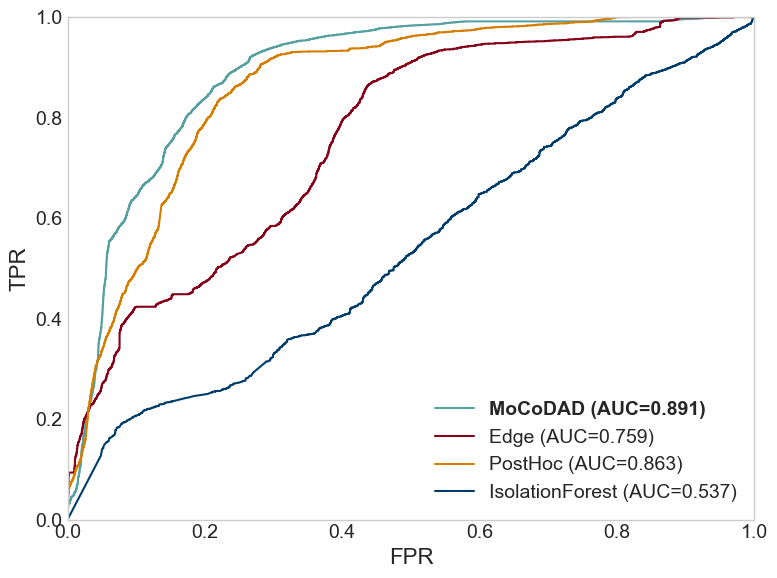

In [ ]:
# plot PR curves
import matplotlib.pyplot as plt

# Use ggplot style
plt.style.use("seaborn-v0_8-whitegrid")

# Set global font to Arial and increase font size
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 14

plt.figure(figsize=(8,6))
plt.plot(md[0], md[1], label=f'MoCoDAD (AUC={auc(md[0], md[1]):.3f})', color="#57A0A2")
plt.plot(edge[0], edge[1], label=f'Edge (AUC={auc(edge[0], edge[1]):.3f})', color="#850018",)
plt.plot(post[0], post[1], label=f'PostHoc (AUC={auc(post[0], post[1]):.3f})', color="#D67D00")
plt.plot(iso[0], iso[1], label=f'IsolationForest (AUC={auc(iso[0], iso[1]):.3f})', color='#003D6B')
plt.xlabel('FPR', fontsize=16)
plt.ylabel('TPR', fontsize=16)
plt.xlim(0,1)
plt.ylim(0,1)
legend = plt.legend(fontsize=14)
plt.grid()
plt.tight_layout()


for text in legend.get_texts():
    if "MoCoDAD" in text.get_text():
        text.set_fontweight("bold")

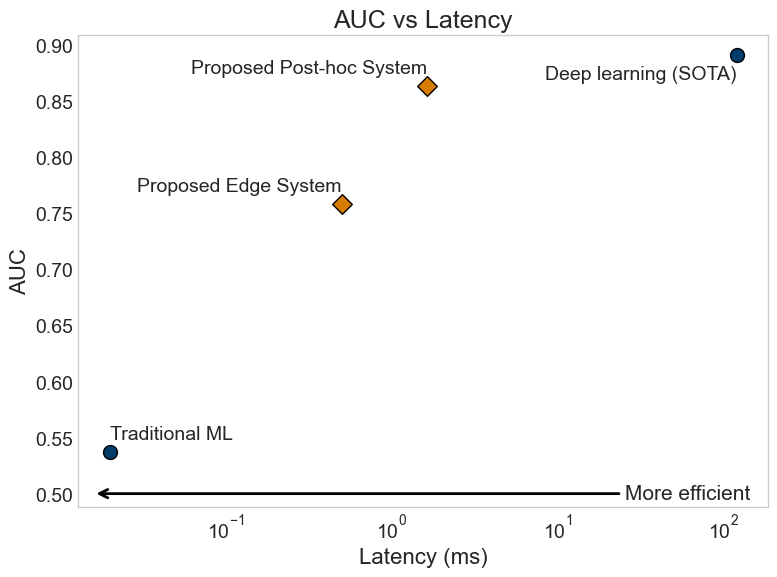

In [16]:
aucs = [auc(md[0], md[1]), auc(edge[0], edge[1]), auc(post[0], post[1]), auc(iso[0], iso[1])]
latencies = [119.3, 0.5, 1.63, 0.02]
methods = ['Deep learning (SOTA)', 'Proposed Edge System', 'Proposed Post-hoc System', 'Traditional ML']
shapes = ['o', 'D', 'D', 'o']
colors = ['#003D6B', '#D67D00', '#D67D00', '#003D6B']

plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 14

# plot the auc vs latency for the exec summary
plt.figure(figsize=(8,6))
for i, method in enumerate(methods):
    plt.scatter(latencies[i], aucs[i], marker=shapes[i], label=method, edgecolor='black', s=100, zorder=3, color=colors[i])
    plt.text(latencies[i], aucs[i]+0.008 if i not in [0] else aucs[i]-0.009, method, fontsize=14, ha='right' if i != 3 else 'left', va='bottom' if i not in [0] else 'top')
plt.xscale('log')
plt.xlabel('Latency (ms)', fontsize=16)
plt.ylabel('AUC', fontsize=16)
plt.title('AUC vs Latency', fontsize=18)
plt.grid()

ymin, ymax = plt.ylim()
plt.ylim(ymin - 0.08*(ymax-ymin), ymax)

y_arrow = ymin - 0.05 * (ymax - ymin)
x_start = min(latencies) * 0.8
x_end = max(latencies) * 1.2
plt.annotate(
    'More efficient',
    xy=(x_start, y_arrow),
    xytext=(x_end, y_arrow),
    arrowprops=dict(arrowstyle='->', lw=2, color='black'),
    fontsize=15,
    ha='right',
    va='center'
)


plt.tight_layout()